<h1> SERIE TEMPORALI

# Import

In [183]:
from google.colab import drive
drive.mount('/content/drive')

# path dataset
file_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/Serie temporali/GlobalLandTemperaturesByCountry.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
!pip install pmdarima
from pmdarima.arima import auto_arima

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tabulate import tabulate
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
%matplotlib inline
from io import StringIO

# plot interattivi
import plotly.express as px


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ETL

In [185]:
with open(file_path, 'r', encoding='utf8') as file:
  df = pd.read_csv(file, delimiter = ',')

df_feature = df.copy()
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


<h3> Eliminiamo le colonne non utili <h3>

In [186]:
colonne_da_mantenere = ['dt', 'AverageTemperature', 'Country']
df.drop(df.columns.difference(colonne_da_mantenere), 1, inplace=True)
df = df.rename(columns={"dt": "Data"})

df

<ipython-input-186-f11c2e2ea9d3>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,Data,AverageTemperature,Country
0,1743-11-01,4.384,Åland
1,1743-12-01,NaN,Åland
2,1744-01-01,NaN,Åland
3,1744-02-01,NaN,Åland
4,1744-03-01,NaN,Åland
...,...,...,...
577457,2013-05-01,19.059,Zimbabwe
577458,2013-06-01,17.613,Zimbabwe
577459,2013-07-01,17.000,Zimbabwe
577460,2013-08-01,19.759,Zimbabwe


<h3> Selezioniamo solo le righe relative all'Italia

In [187]:
df_italy = df[df['Country'] == 'Italy']
df_italy

,Data,AverageTemperature,Country
261968,1743-11-01,9.538,Italy
261969,1743-12-01,NaN,Italy
261970,1744-01-01,NaN,Italy
261971,1744-02-01,NaN,Italy
261972,1744-03-01,NaN,Italy
...,...,...,...
265202,2013-05-01,15.446,Italy
265203,2013-06-01,19.764,Italy
265204,2013-07-01,23.651,Italy
265205,2013-08-01,23.603,Italy


<h3> Trasformiamo la data in un datetime e la settiamo come indice <h3>

In [188]:
df_italy["Data"] = pd.to_datetime(df_italy["Data"])
df_italy = df_italy.set_index("Data")

df_italy

<ipython-input-188-9cbe32d6ac15>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AverageTemperature,Country
Data,,
1743-11-01,9.538,Italy
1743-12-01,NaN,Italy
1744-01-01,NaN,Italy
1744-02-01,NaN,Italy
1744-03-01,NaN,Italy
...,...,...
2013-05-01,15.446,Italy
2013-06-01,19.764,Italy
2013-07-01,23.651,Italy


In [189]:
df_italy.describe()

,AverageTemperature
count,3166.000000
mean,12.737122
std,6.479438
min,-1.217000
25%,6.827750
50%,12.208500
75%,18.896250
max,26.120000


In [190]:
df_italy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 1743-11-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  3166 non-null   float64
 1   Country             3239 non-null   object 
dtypes: float64(1), object(1)
memory usage: 75.9+ KB


In [191]:
y = 'AverageTemperature'

In [192]:
df_italy[df_italy[y].isna()]

,AverageTemperature,Country
Data,,
1743-12-01,NaN,Italy
1744-01-01,NaN,Italy
1744-02-01,NaN,Italy
1744-03-01,NaN,Italy
1744-08-01,NaN,Italy
...,...,...
1752-06-01,NaN,Italy
1752-07-01,NaN,Italy
1752-08-01,NaN,Italy


<h3> Eliminiamo i dati fino al 1900 e togliamo l'ultimo elemento (in questo modo eliminiamo tutti i valori nulli)

In [193]:
df_italy = df_italy[df_italy.index>='1900-01-01'][:-1]

df_italy

,AverageTemperature,Country
Data,,
1900-01-01,5.402,Italy
1900-02-01,7.367,Italy
1900-03-01,5.893,Italy
1900-04-01,9.725,Italy
1900-05-01,14.543,Italy
...,...,...
2013-04-01,12.642,Italy
2013-05-01,15.446,Italy
2013-06-01,19.764,Italy


# Analisi relativa ai singoli mesi

## Analisi del dataset

In [194]:
px.line(data_frame=df_italy, x=df_italy.index, y= y)

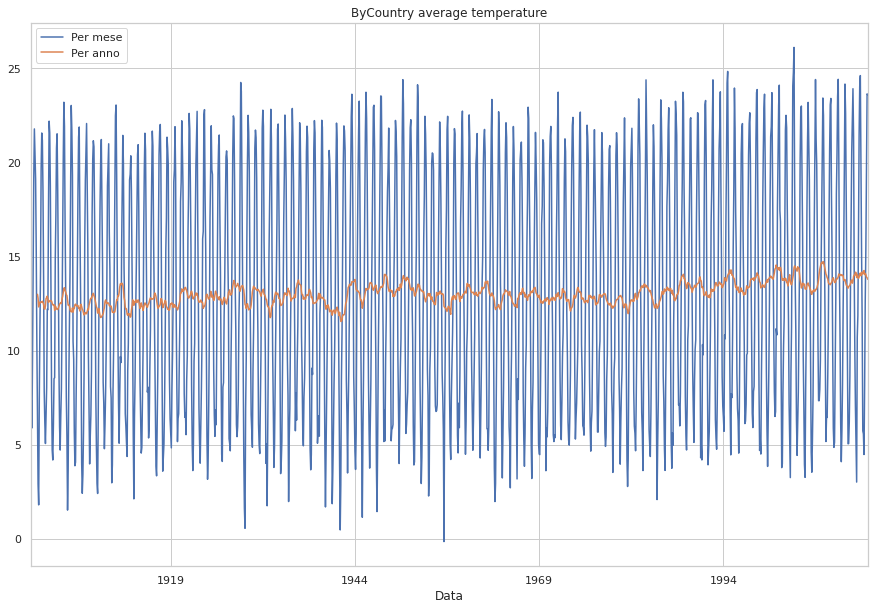

In [195]:
plt.figure(figsize = (15,10))
plt.title("ByCountry average temperature")
df_italy[y].plot(label = 'Per mese')
df_italy[y].rolling(window = 12).mean().plot(label='Per anno')
plt.legend()
plt.show()


### Decomposizione e analisi di trend, stagionalità e residui

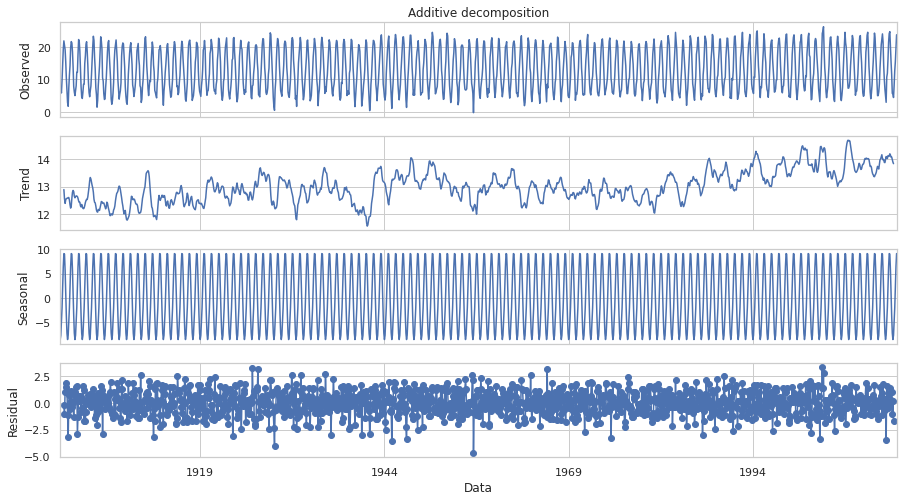

In [196]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15, 8))

decomposition = sm.tsa.seasonal_decompose(df_italy[y], period = 12, model='additive') 
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Additive decomposition')
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].scatter(np.array(decomposition.resid.index), decomposition.resid)
axes[3].set_ylabel('Residual')
plt.show()

<h3> Tagliamo la prima parte dei dati e li dividiamo in train e test <h3>

In [197]:
df_italy_train = df_italy[df_italy.index<='2000/01/01']
df_italy_test = df_italy[df_italy.index>'2000/01/01']

In [198]:
df_italy_train

,AverageTemperature,Country
Data,,
1900-01-01,5.402,Italy
1900-02-01,7.367,Italy
1900-03-01,5.893,Italy
1900-04-01,9.725,Italy
1900-05-01,14.543,Italy
...,...,...
1999-09-01,20.195,Italy
1999-10-01,15.182,Italy
1999-11-01,8.982,Italy


In [199]:
df_italy_test

,AverageTemperature,Country
Data,,
2000-02-01,6.436,Italy
2000-03-01,8.957,Italy
2000-04-01,12.447,Italy
2000-05-01,17.879,Italy
2000-06-01,21.373,Italy
...,...,...
2013-04-01,12.642,Italy
2013-05-01,15.446,Italy
2013-06-01,19.764,Italy


In [200]:
px.line(data_frame = df_italy_train, x = df_italy_train.index, y = y)

In [201]:
px.line(data_frame = df_italy_test, x= df_italy_test.index, y = y)

### Decomponiamo la serie temporale di training

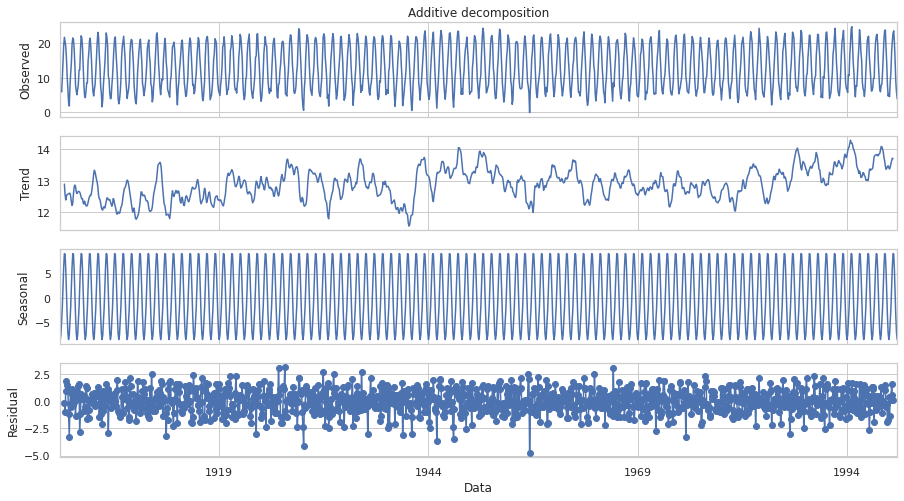

In [202]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15, 8))

decomposition = sm.tsa.seasonal_decompose(df_italy_train[y], period = 12, model='additive') 
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Additive decomposition')
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].scatter(np.array(decomposition.resid.index), decomposition.resid)
axes[3].set_ylabel('Residual')
plt.show()

In [203]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [204]:
test_stationarity(df_italy_train[y])

Test Statistic            -4.040247
p-value                    0.001214
Lags                      23.000000
Observations            1177.000000
Critical Value (1%)       -3.435918
Critical Value (5%)       -2.863999
Critical Value (10%)      -2.568079
dtype: float64


 Sembra essere stazionaria, quindi non serve differenziare

### Autocorrelazione e autocorrelazione parziale


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



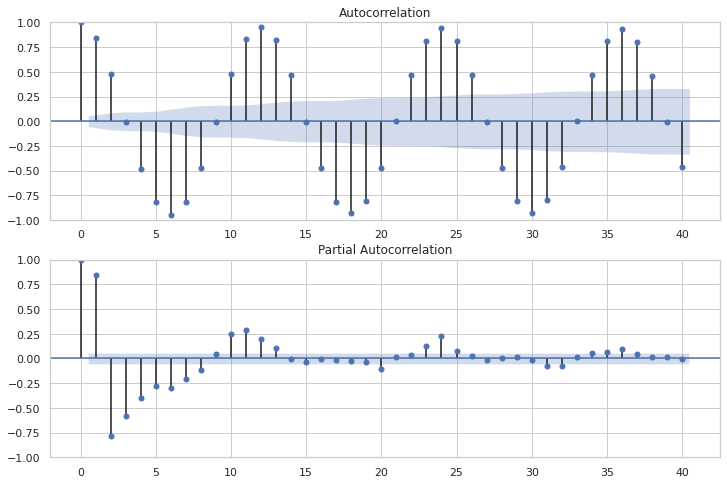

In [205]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_italy_train[y][1:], lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_italy_train[y][1:], lags=40, ax=ax2)

## Creazione modello allenato sul dataset di train

### Creiamo un modello ARIMA esplorativo

In [206]:
p, d, q = 1, 0, 2

arima_model = ARIMA(df_italy_train[y], order=(p,d,q)) 
trained_model = arima_model.fit()

print(trained_model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 1201
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2813.128
Date:                Thu, 19 Jan 2023   AIC                           5636.257
Time:                        09:43:22   BIC                           5661.712
Sample:                    01-01-1900   HQIC                          5645.845
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8447      0.514     24.977      0.000      11.837      13.853
ar.L1          0.7055      0.028     25.424      0.000       0.651       0.760
ma.L1          0.5831      0.034     17.238      0.0

<h3> Plot delle previsioni <h3>

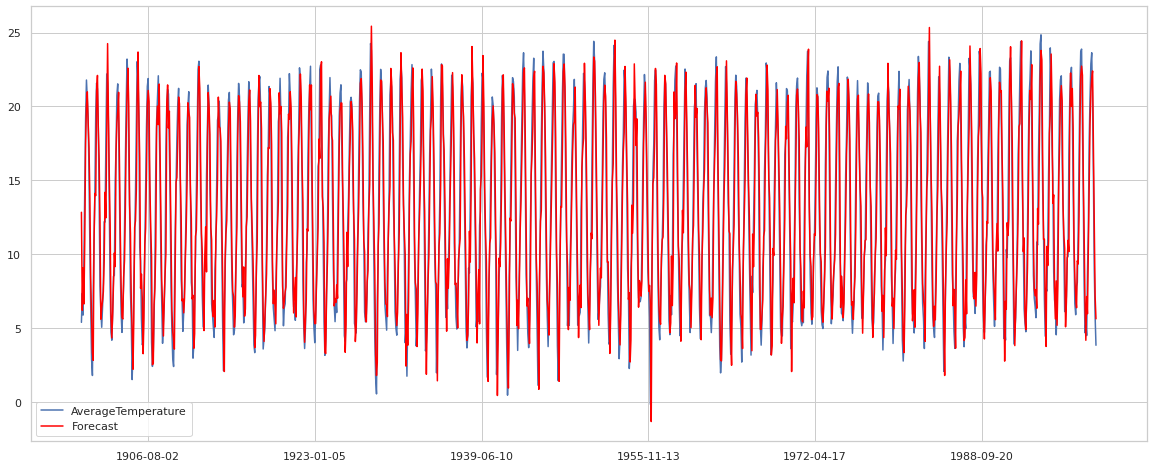

In [207]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_italy_train[y])
plt.plot(trained_model.fittedvalues, color='red')
ax.legend([y, 'Forecast'])

ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [208]:
residuals = pd.DataFrame(trained_model.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



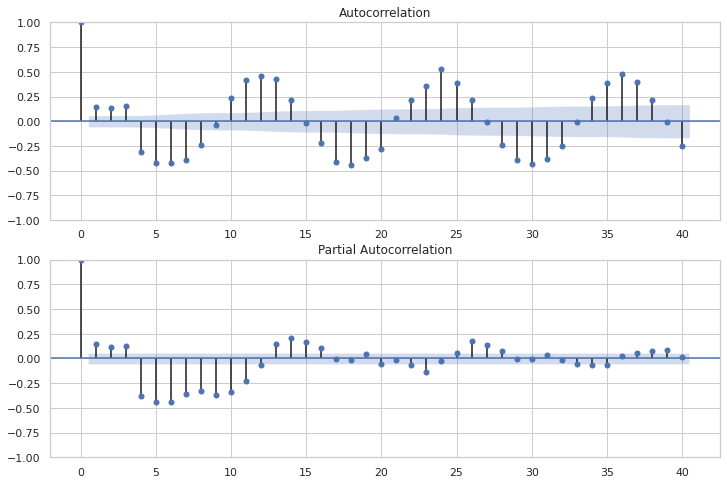

In [209]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Il modello non è adatto, poiché rimangono molte componenti al di fuori della regione di ammissibilità; ciò accade perchè non abbiamo considerato la stagionalità

<h3> Plot della distribuzione dei residui <h3>

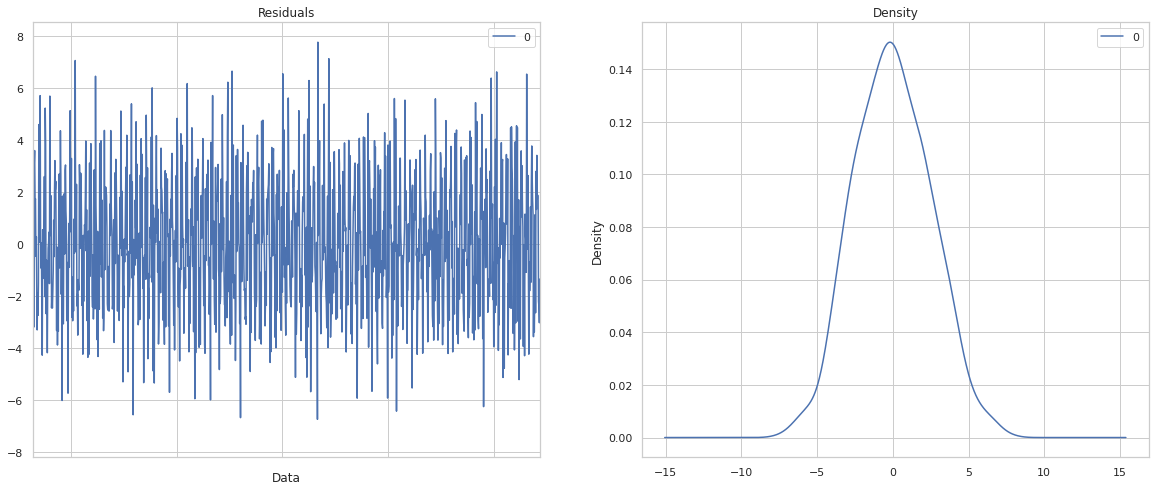

In [210]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

I residui non sono piccoli e non seguono una gaussiana, quindi il modello non va bene; questo accade perchè non abbiamo considerato la stagionalità

## Cerchiamo il miglior modello ARIMA

<h3> Auto ARIMA per determinare il miglior modello

In [211]:
auto_model = auto_arima(df_italy_train[y], 
                      # d=0,
                      # D=0,
                      start_p=0, 
                      start_q=0,
                      max_p=5, 
                      max_q=5,
                      start_P=0, 
                      start_Q=0,
                      max_P=5, 
                      max_Q=5,
                      test='adf',
                      m=12,
                      trace=True,
                      seasonal=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7843.679, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6057.451, Time=3.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9810.613, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6711.673, Time=0.57 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=11.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=5629.027, Time=8.87 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3911.573, Time=23.14 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=3965.731, Time=34.57 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=5325.762, Time=11.00 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=4513.335, Time=11.24 sec
 ARIMA(0,0,1)(2,0,3)[12] intercept   : AIC=inf, Time=38.93 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=12.09 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept  

<h3> Alleniamo un modello nuovo con i parametri ottimi

In [212]:
# p_best, d_best, q_best = 1, 0, 1
# P_best, D_best, Q_best , m = 2, 0, 1, 12

p_best, d_best, q_best = 2, 0, 3
P_best, D_best, Q_best , m = 1, 0, 2, 12


arima_model = ARIMA(df_italy_train[y], order = (p_best,d_best,q_best), seasonal_order = (P_best, D_best, Q_best, m)) 
sarima_ottimo = arima_model.fit()
print(sarima_ottimo.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                       
Dep. Variable:                    AverageTemperature   No. Observations:                 1201
Model:             ARIMA(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1938.861
Date:                               Thu, 19 Jan 2023   AIC                           3897.722
Time:                                       09:47:58   BIC                           3948.631
Sample:                                   01-01-1900   HQIC                          3916.898
                                        - 01-01-2000                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8559      0.615     22.516      0.000      12.650      15.062
ar.L1      

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [213]:
residuals = pd.DataFrame(sarima_ottimo.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



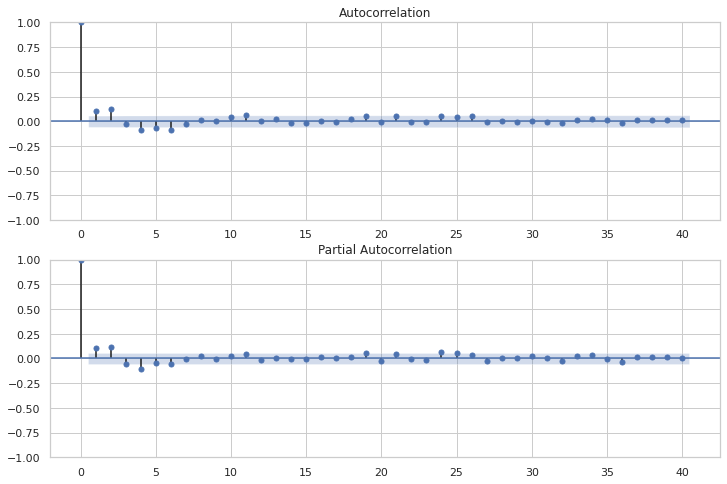

In [214]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Il modello riesce ad interpretare tutta la correlazione della serie, perché tutti i lag successivi al primo hanno valori molto bassi

<h3> Plot della distribuzione dei residui <h3>

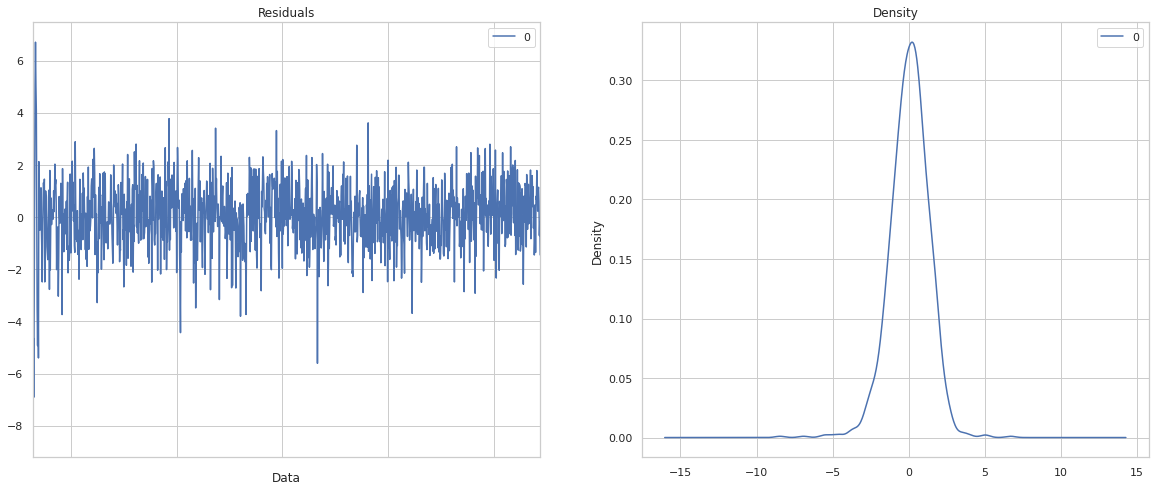

In [215]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

I residui sono piccoli e seguono una gaussiana, quindi il modello va bene

### Visualizzazione sul Training Set

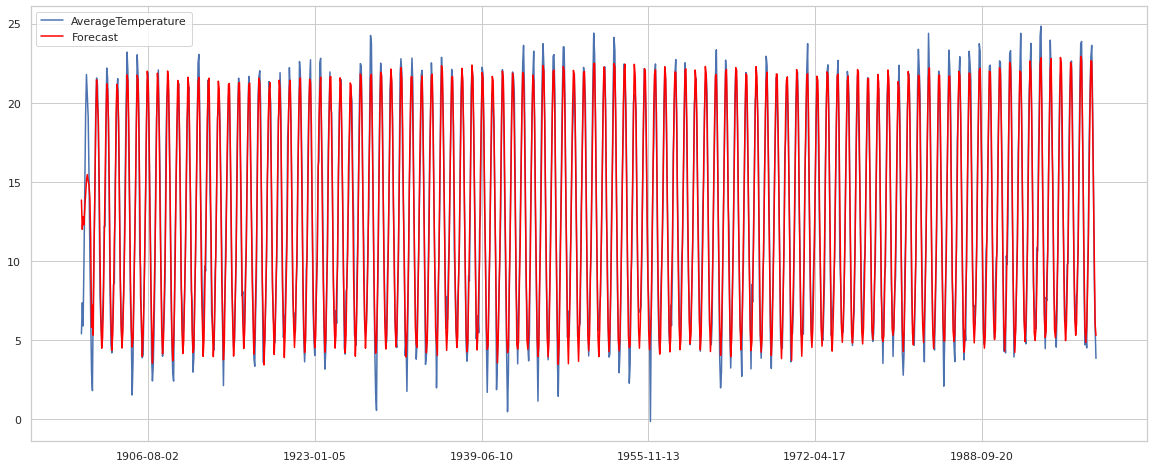

In [216]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_italy_train[y])
plt.plot(sarima_ottimo.fittedvalues, color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

<h3> Visualizziamo la previsione su un sottoinsieme dei dati di training <h3>

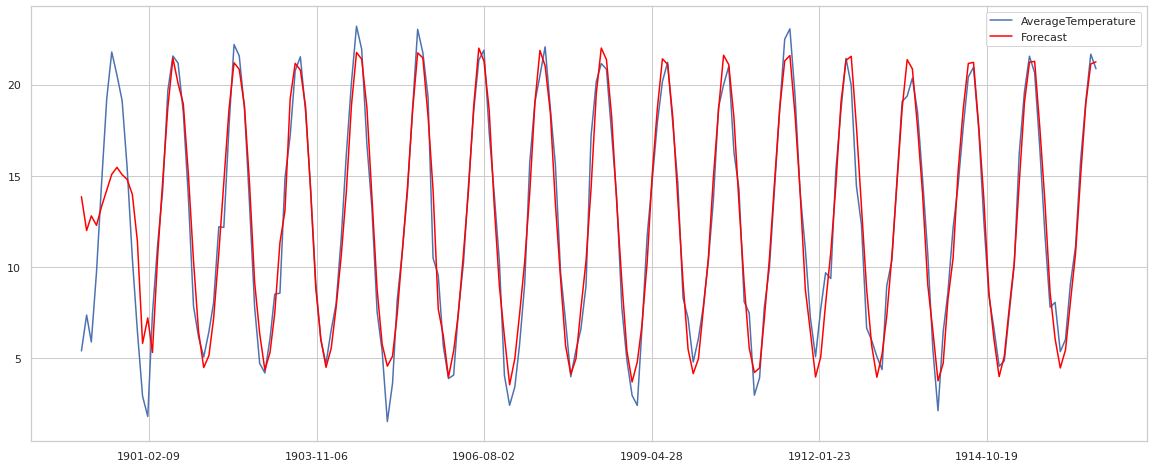

In [217]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_italy_train[y][:200])
plt.plot(sarima_ottimo.fittedvalues[:200], color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Previsioni su Test Set

<h3> Ultimo giorno del training set <h3>

In [218]:
df_italy_train[y].tail(1)

Data
2000-01-01    3.851
Name: AverageTemperature, dtype: float64

<h3> Prevediamo i successivi n valori <h3>

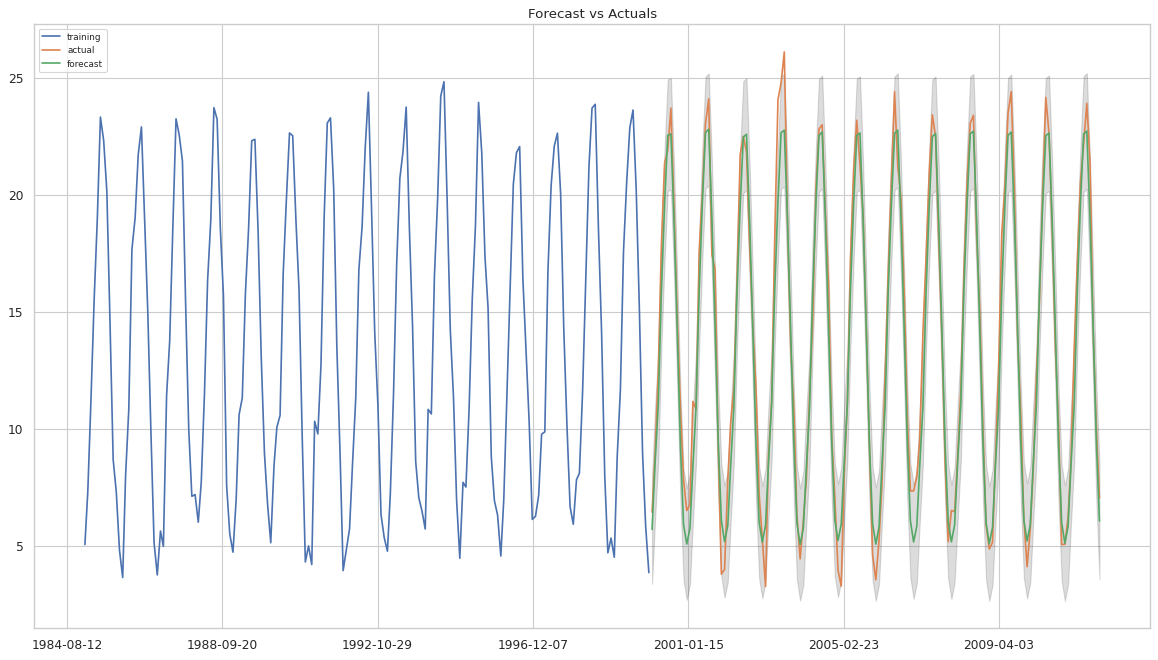

In [222]:
step = len(df_italy_test)-20

# Forecast
fcast = sarima_ottimo.get_forecast(steps = step, alpha=0.05).summary_frame()

fc_series = pd.DataFrame(fcast["mean"], index=fcast.index)
lower_series = pd.Series(fcast['mean_ci_upper'].values, index=fcast.index)
upper_series = pd.Series(fcast['mean_ci_lower'].values, index=fcast.index)

# Plot
fig, ax = plt.subplots(figsize=(18,10), dpi=80)
plt.plot(df_italy_train[y][-180:], label='training')
plt.plot(df_italy_test[y][:step], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
# df_italy_train[y][-200:].rolling(window = 12).mean().plot(label='Per anno')
# df_italy_test[y].rolling(window = 12).mean().plot(label='Per anno')
# fc_series['mean'].rolling(window = 12).mean().plot(label='Per anno')


plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

plt.show()

In [220]:
mae = round(metrics.mean_absolute_error(df_italy_test[y], fc_series), 4) 

mse = round(metrics.mean_squared_error(df_italy_test[y], fc_series), 4) 

rmse = round(np.sqrt(mse), 4)

mad = round(metrics.median_absolute_error(df_italy_test[y], fc_series), 4)

r2 = round(metrics.r2_score(df_italy_test[y], fc_series), 4)

mape = metrics.mean_absolute_percentage_error(y_true = df_italy_test[y], y_pred = fc_series)

mae, mse, rmse, mad, r2, mape

(1.0497, 1.7081, 1.3069, 0.9003, 0.9612, 0.10381316255076382)

In [221]:
df_forecast = pd.concat([fc_series.apply(lambda x: round(x, 1)), df_italy_test[y][:step]], axis=1)
df_forecast.columns = ['Forecast', 'Actuals']

df_forecast

,Forecast,Actuals
2000-02-01,5.7,6.436
2000-03-01,8.5,8.957
2000-04-01,11.0,12.447
2000-05-01,15.9,17.879
2000-06-01,19.6,21.373
...,...,...
2013-04-01,11.0,12.642
2013-05-01,15.9,15.446
2013-06-01,19.7,19.764
2013-07-01,22.6,23.651
